In [1]:
import pandas as pd
import numpy as np
import time
import pathlib
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from gosdt.model.threshold_guess import compute_thresholds, cut
from gosdt.model.gosdt import GOSDT

**Below we show examples on how to run f1, auc convex hull, and partial auc convex hull using GOSDT. Note that optimization for these objectives are slower than optimizing accuracy and balanced accuracy, since dynamic programming can not be applied.**


### Example 1 (Monk 1)

We first show examples using Monk 1 dataset. 

In [2]:
from sklearn.preprocessing import OneHotEncoder
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/monks-problems/monks-1.train", sep=" ", header=None)
df = df.iloc[:,1:-1]

# assign column names 
df.columns = ["label", "head_shape", "body_shape", "is_smiling", "holding", "jacket_color", "has_tie"]
X = df.iloc[:,1:]
y = df.iloc[:,0]
y = pd.DataFrame(y)

# Encode the categorical features to binary features
enc = OneHotEncoder()
enc.fit(X)
X = pd.DataFrame(enc.transform(X).toarray(), dtype=int)
X.columns = ["head_shape_round", "head_shape_square", "head_shape_octagon", 
                 "body_shape_round", "body_shape_square", "body_shape_octagon",
                 "is_smiling_yes", "is_smiling_no", 
                 "holding_sword", "holding_balloon", "holding_flag",
                 "jacket_color_red", "jacket_color_yellow", "jacket_color_green", "jacket_color_blue",
                 "has_tie_yes", "has_tie_no"
                ]
X.head()

,head_shape_round,head_shape_square,head_shape_octagon,body_shape_round,body_shape_square,body_shape_octagon,is_smiling_yes,is_smiling_no,holding_sword,holding_balloon,holding_flag,jacket_color_red,jacket_color_yellow,jacket_color_green,jacket_color_blue,has_tie_yes,has_tie_no
0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0
1,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1
2,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0
3,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1
4,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0


Below is an example to set up the configuration. For ``accuracy``, ``balanced accuracy``, ``weighted accuracy``, we suggest using C++ version, since it uses the dynamic programming and can be much faster. 

**F1 score**: 
{ "objective": "f1", "w": 0.9, "theta": None}. You need to specify hyperparameter $w \in (0,1)$. This is because optimizing F-score is much harder than other arbitrary monotonic losses.Thus,we simplify the labeling step by incorporating a parameter $w$ at each leaf node. 

**AUC convex hull**: { "objective": "auc", "w": None, "theta": None } 

**Partial AUC convex hull**: { "objective": "pauc", "w": None, "theta": 0.1 } You need to specify hyperparameter $\theta \in (0,1)$. $\theta$ is used to specify the left most part of the ROC curve. 

#### (a) F1 objective

In [3]:
config={
        "regularization": 0.01,
        "objective": "f1",
        "w": 0.9,
        "time_limit": 60
}

In [4]:
model = GOSDT(config)

In [5]:
model.fit(X, y)

loss function: f1
lambda:  0.01
COUNT_UNIQLEAVES: 2185
COUNT_LEAFLOOKUPS: 80609
total time:  9.146592378616333
leaves:  [(1,), (-9, -1, 2), (-1, 2, 9), (-13, -3, -2, -1), (-3, -2, -1, 13), (-12, -2, -1, 3), (-2, -1, 3, 12)]
num_captured:  [29, 31, 8, 20, 12, 11, 13]
prediction:  [1, 0, 1, 0, 1, 0, 1]
Objective:  0.07
f1 :  1.0
COUNT of the best tree:  3476
time when the best tree is achieved:  0.23038196563720703
TOTAL COUNT:  176434


Decode leaves

In [6]:
model.tree.source

{'feature': 11,
 'name': 'jacket_color_red',
 'reference': 1,
 'relation': '==',
 'true': {'complexity': 0.01, 'loss': 0.0, 'name': 'class', 'prediction': 1},
 'false': {'feature': 0,
  'name': 'head_shape_round',
  'reference': 1,
  'relation': '==',
  'true': {'feature': 3,
   'name': 'body_shape_round',
   'reference': 1,
   'relation': '==',
   'true': {'complexity': 0.01, 'loss': 0.0, 'name': 'class', 'prediction': 1},
   'false': {'complexity': 0.01,
    'loss': 0.0,
    'name': 'class',
    'prediction': 0}},
  'false': {'feature': 2,
   'name': 'head_shape_octagon',
   'reference': 1,
   'relation': '==',
   'true': {'feature': 5,
    'name': 'body_shape_octagon',
    'reference': 1,
    'relation': '==',
    'true': {'complexity': 0.01,
     'loss': 0.0,
     'name': 'class',
     'prediction': 1},
    'false': {'complexity': 0.01,
     'loss': 0.0,
     'name': 'class',
     'prediction': 0}},
   'false': {'feature': 4,
    'name': 'body_shape_square',
    'reference': 1,
   

We can now explore more about the obtained tree. 

In [7]:
acc = model.score(X, y) # calculate the accuracy
n_leaves = model.leaves()
n_nodes = model.nodes()

print("Model training time: {}".format(model.duration))
print("Training accuracy: {}".format(acc))
print("# of leaves: {}".format(n_leaves))

Model training time: 9.1525593
Training accuracy: 1.0
# of leaves: 7


In [8]:
# Note that if you want to test f1 metric, tree.score() won't work. 
from sklearn.metrics import f1_score
y_hat = model.predict(X)
print("f1 score:", f1_score(y, y_hat))

f1 score: 1.0


#### (b) AUC convex hull objective

In [9]:
config={
        "regularization": 0.01,
        "objective": "auc",
        "time_limit": 60
}
model = GOSDT(config)
model.fit(X, y)
print(model.tree.source)

loss function: auc
lambda:  0.01
COUNT_UNIQLEAVES: 3087
COUNT_LEAFLOOKUPS: 99455
total time:  56.81161284446716
leaves:  [(1,), (-12, -1, 3), (-1, 3, 12), (-14, -9, -3, -1), (-14, -3, -1, 9), (-13, -3, -1, 14), (-3, -1, 13, 14)]
num_captured:  [29, 11, 13, 31, 8, 20, 12]
prediction:  [1, 1, 1, 1, 1, 1, 1]
Objective:  0.07
auc :  1.0
COUNT of the best tree:  52236
time when the best tree is achieved:  14.399035930633545
TOTAL COUNT:  247840
{'feature': 11, 'name': 'jacket_color_red', 'reference': 1, 'relation': '==', 'true': {'complexity': 0.01, 'loss': 0.0, 'name': 'class', 'prediction': 1}, 'false': {'feature': 2, 'name': 'head_shape_octagon', 'reference': 1, 'relation': '==', 'true': {'feature': 5, 'name': 'body_shape_octagon', 'reference': 1, 'relation': '==', 'true': {'complexity': 0.01, 'loss': 0.0, 'name': 'class', 'prediction': 1}, 'false': {'complexity': 0.01, 'loss': 0.08870967741935482, 'name': 'class', 'prediction': 1}}, 'false': {'feature': 1, 'name': 'head_shape_square', '

The algorithm can finish running within 60 seconds time limit. You may find one thing above is interesting. Prediction vector contains all ones. This is because for ``auc`` and ``pauc`` metric, we are optimizing the convex hull. Code below can be used to draw ROC curve for ``auc`` and ``pauc`` objectives. 

In [10]:
def helper(node, X, y):
    node["pos_neg"] = [y.sum()[0], y.shape[0]-y.sum()[0], y.sum()[0]/y.shape[0]]
    
    if "relation" in node:
        if node["relation"] == "==":
            X_left = X[X[node["name"]] == node["reference"]]
            y_left = y[X[node["name"]] == node["reference"]]
            X_right = X[X[node["name"]] != node["reference"]]
            y_right = y[X[node["name"]] != node["reference"]]
    else:
        X_left, y_left, X_right, y_right = None, None, None, None
    return node, X_left, y_left, X_right, y_right
        

def add_prob(tree, X, y):
    pos_neg = []
    nodes = [tree]
    data = [[X, y]]
    while len(nodes) > 0:
        node = nodes.pop()
        data_tmp = data.pop()
        X = data_tmp[0]
        y = data_tmp[1]
        node, X_left, y_left, X_right, y_right = helper(node, X, y)
        if "prediction" not in node:
            nodes.append(node["true"])
            data.append([X_left, y_left])
            nodes.append(node["false"])
            data.append([X_right, y_right])
        else:
            pos_neg.append(node["pos_neg"])
    return pos_neg

def plot_roc(tree, X, y):
    # plot roc curve for auc and pauc objective
    pos_neg = add_prob(tree, X, y)
    pos_neg = np.array(pos_neg).T
    
    P = np.count_nonzero(y) # positive samples
    N = len(y) - P
    
    pos_neg = pos_neg[:,np.argsort(pos_neg[2,])]
    pos_neg = np.flip(pos_neg, axis=1)
    pos_neg = np.cumsum(pos_neg,axis=1)
    init = np.array([[0], [0], [0]])
    pos_neg = np.append(init, pos_neg, axis=1)  
    tp = pos_neg[0, :]
    fp = pos_neg[1, :]
    out = 0.5*sum([(pos_neg[0,i]+pos_neg[0,i-1])*(pos_neg[1,i]-pos_neg[1,i-1])/(P*N) for i in range(1,len(tp))])
    print("area under roc curve:", out)
    plt.plot([f/N for f in fp], [f/P for f in tp], 'go-', linewidth=2)


area under roc curve: 1.0


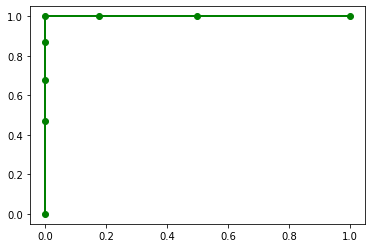

In [11]:
import copy
from matplotlib import pyplot as plt
a = copy.deepcopy(model.tree.source)       
plot_roc(a, X, y)

#### (c) Partial AUC convex hull objective

In [12]:
config={
        "regularization": 0.01,
        "objective": "pauc",
        "theta": 0.2,
        "time_limit": 60
}
model = GOSDT(config)
model.fit(X, y)
print(model.tree.source)

loss function: pauc
lambda:  0.01
COUNT_UNIQLEAVES: 4968
COUNT_LEAFLOOKUPS: 159398
total time:  60.001120805740356
leaves:  [(1,), (-9, -1, 2), (-1, 2, 9), (-14, -12, -2, -1), (-14, -2, -1, 12), (-13, -2, -1, 14), (-2, -1, 13, 14)]
num_captured:  [29, 31, 8, 11, 13, 20, 12]
prediction:  [1, 1, 1, 1, 1, 1, 1]
Objective:  0.8700000000000001
pauc :  0.19999999999999996
COUNT of the best tree:  154031
time when the best tree is achieved:  40.786935567855835
TOTAL COUNT:  240889
{'feature': 11, 'name': 'jacket_color_red', 'reference': 1, 'relation': '==', 'true': {'complexity': 0.01, 'loss': 0.0, 'name': 'class', 'prediction': 1}, 'false': {'feature': 0, 'name': 'head_shape_round', 'reference': 1, 'relation': '==', 'true': {'feature': 3, 'name': 'body_shape_round', 'reference': 1, 'relation': '==', 'true': {'complexity': 0.01, 'loss': 0.0, 'name': 'class', 'prediction': 1}, 'false': {'complexity': 0.01, 'loss': 0.24999999999999983, 'name': 'class', 'prediction': 1}}, 'false': {'feature': 1,

The algorithm cannot finish running within 60 seconds time limit and returns the best tree so far. We can also draw the ROC curve. You may find that this pauc convex hull value different from output above. This is because we calculate the whole area under the ROC curve here, but previous is only the area for the top theta proportion. 

area under roc curve: 1.0


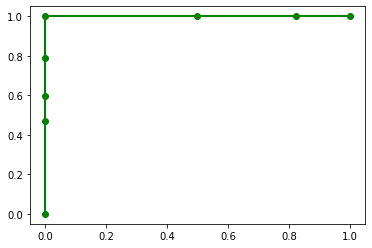

In [13]:
a = copy.deepcopy(model.tree.source)       
plot_roc(a, X, y)

### Example on running on FourClass dataset
Monk1 is not very interesting. Different objectives end up with the same ROC curve. In the second example, we run on Four Class dataset

In [14]:
df = pd.read_csv(
    "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/fourclass", sep="\s+|:", header=None, engine="python")

In [15]:
X = df.iloc[:,[2,4]].astype(int)
X.columns = ["f1", "f2"]
y = df.iloc[:,0]
y = pd.DataFrame(y)
y[y==-1] = 0

In [16]:
X.head()

,f1,f2
0,167,178
1,162,31
2,142,96
3,132,169
4,169,74


These two features are continuous. We use threshold guess to preprocess the data. 

In [17]:
# GBDT parameters for threshold and lower bound guesses
n_est = 40
max_depth = 1
# guess thresholds
X_guessed, thresholds, header, threshold_guess_time = compute_thresholds(X.copy(), y, n_est, max_depth)
print(X_guessed.shape)
print(X_guessed.head())

(862, 7)
   f1<=70.5  f1<=73.5  f1<=114.5  f1<=120.5  f1<=143.5  f2<=82.5  f2<=167.5
0         0         0          0          0          0         0          0
1         0         0          0          0          0         1          1
2         0         0          0          0          1         0          1
3         0         0          0          0          1         0          0
4         0         0          0          0          0         1          1


#### (a) F1 objective

In [18]:
config={
        "regularization": 0.01,
        "objective": "f1",
        "w": 0.9,
        "time_limit": 60
}
model = GOSDT(config)

In [19]:
model.fit(X_guessed, y)

loss function: f1
lambda:  0.01
COUNT_UNIQLEAVES: 80
COUNT_LEAFLOOKUPS: 14
total time:  0.24343013763427734
leaves:  [(1,), (-1, 6), (-7, -6, -1), (-6, -4, -1, 7), (-6, -1, 4, 7)]
num_captured:  [294, 230, 65, 138, 135]
prediction:  [0, 1, 0, 1, 0]
Objective:  0.29444444444444445
f1 :  0.7555555555555555
COUNT of the best tree:  116
time when the best tree is achieved:  0.2224864959716797
TOTAL COUNT:  133


In [20]:
acc = model.score(X_guessed, y)
n_leaves = model.leaves()
n_nodes = model.nodes()

print("Model training time: {}".format(model.duration))
print("Training accuracy: {}".format(acc))
print("# of leaves: {}".format(n_leaves))

Model training time: 0.24345089999999914
Training accuracy: 0.808584686774942
# of leaves: 5


In [21]:
# Note that if you want to test f1 metric, tree.score() won't work. 
from sklearn.metrics import f1_score
y_hat = model.predict(X_guessed)
print("f1 score:", f1_score(y, y_hat)) # the value matches the printout above. 

f1 score: 0.7555555555555555


#### (b) AUC convex hull objective

In [22]:
config={
        "regularization": 0.01,
        "objective": "auc",
        "time_limit": 60
}
model = GOSDT(config)
model.fit(X_guessed, y)
print(model.tree.source)

loss function: auc
lambda:  0.01
COUNT_UNIQLEAVES: 655
COUNT_LEAFLOOKUPS: 112127
total time:  60.00080442428589
leaves:  [(2,), (-4, -2, 6), (-6, -2, 4), (-2, 4, 6), (-7, -6, -4, -2), (-6, -4, -2, 7)]
num_captured:  [278, 114, 153, 123, 56, 138]
prediction:  [1, 1, 1, 1, 1, 1]
Objective:  0.16208645127211901
auc :  0.897913548727881
COUNT of the best tree:  4523
time when the best tree is achieved:  3.0249080657958984
TOTAL COUNT:  95088
{'feature': 0, 'name': 'f1<=70.5', 'reference': 1, 'relation': '==', 'true': {'complexity': 0.01, 'loss': 0.31322505800464034, 'name': 'class', 'prediction': 1}, 'false': {'feature': 3, 'name': 'f1<=120.5', 'reference': 1, 'relation': '==', 'true': {'feature': 5, 'name': 'f2<=82.5', 'reference': 1, 'relation': '==', 'true': {'complexity': 0.01, 'loss': 0.07540603248259867, 'name': 'class', 'prediction': 1}, 'false': {'complexity': 0.01, 'loss': 0.1299303944315549, 'name': 'class', 'prediction': 1}}, 'false': {'feature': 5, 'name': 'f2<=82.5', 'referenc

area under roc curve: 0.897913548727881


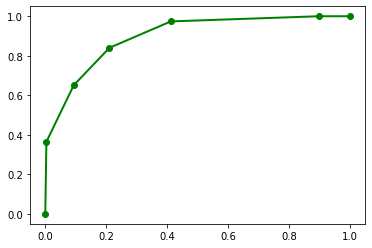

In [23]:
a = copy.deepcopy(model.tree.source)       
plot_roc(a, X_guessed, y)

#### (c) Partial AUC convex hull objective

In [24]:
config={
        "regularization": 0.01,
        "objective": "pauc",
        "theta": 0.2,
        "time_limit": 60
}
model = GOSDT(config)
model.fit(X_guessed, y)
print(model.tree.source)

loss function: pauc
lambda:  0.01
COUNT_UNIQLEAVES: 829
COUNT_LEAFLOOKUPS: 229855
total time:  60.00115752220154
leaves:  [(4,), (-4, 6), (-7, -6, -4), (-6, -4, 7)]
num_captured:  [554, 114, 56, 138]
prediction:  [1, 1, 1, 1]
Objective:  0.9218638392234353
pauc :  0.11813616077656475
COUNT of the best tree:  36
time when the best tree is achieved:  0.02991962432861328
TOTAL COUNT:  115120
{'feature': 3, 'name': 'f1<=120.5', 'reference': 1, 'relation': '==', 'true': {'complexity': 0.01, 'loss': 0.5185614849187898, 'name': 'class', 'prediction': 1}, 'false': {'feature': 5, 'name': 'f2<=82.5', 'reference': 1, 'relation': '==', 'true': {'complexity': 0.01, 'loss': 0.002320185614849188, 'name': 'class', 'prediction': 1}, 'false': {'feature': 6, 'name': 'f2<=167.5', 'reference': 1, 'relation': '==', 'true': {'complexity': 0.01, 'loss': 0.058004640371229696, 'name': 'class', 'prediction': 1}, 'false': {'complexity': 0.01, 'loss': 0.06496519721577726, 'name': 'class', 'prediction': 1}}}}


area under roc curve: 0.8123866537547318


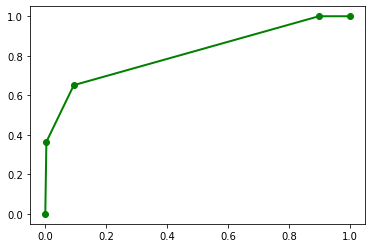

In [25]:
a = copy.deepcopy(model.tree.source)       
plot_roc(a, X_guessed, y)

In this example, we can see different ROC curve when optimizing different objectives. 